<a href="https://colab.research.google.com/github/kennedymay/Comp20-Homework/blob/main/CS135FINALPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Dependencies

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, svm
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np 
from sklearn.metrics import accuracy_score, confusion_matrix


pd.options.mode.chained_assignment = None

# Importing the NBA Player Data
For our primary dataset, we used the [NBA Players Dataset](https://www.kaggle.com/datasets/justinas/nba-players-data), which contains 20+ years of data on every player that has been a part of an NBA team's roster. In the dataset, for each player in each season, there are datapoints containing demographic information *(i.e. age, height, etc.)*, biographical information *(i.e. draft pick, team drafted to, etc.)*, and basic stats *(i.e. games played, points, etc.)*.


In [ ]:
# Import the dataset and store in a Pandas Dataframe
player_data = pd.read_csv('/content/sample_data/all_seasons.csv')

# Isolate the draft picks in the data 
draft_picks = player_data[player_data['draft_round'] != 'Undrafted']

# Get the data only from each player's rookie year (from 2001 - 2020)
draft_picks['season'] = draft_picks['season'].str.slice(0,4)
draft_picks['season'] = draft_picks['season'].astype(int)
draft_picks['draft_year'] = draft_picks['draft_year'].astype(int)
draft_picks = draft_picks[draft_picks['draft_year'] > 2000]
rookies = draft_picks[draft_picks['draft_year'] == draft_picks['season']]

# Measuring Player Success: Total Output
The main goal of this project is to determine the success of a draft pick in their Rookie Year. We decided the optimal measurement of the success of a player's season is what we're calling **Total Output**. Total Output is calculated by: <br><br/>
$TO = GP * (PPG + APG + RBP)$ where:<br><br/>
$TO$ = Total Output<br>
$GP$ = Games Played<br>
$PPG$ = Points Per Game<br>
$APG$ = Assists Per Game<br>
$RBP$ = Rebounds Per Game


In [ ]:
# Calculate Average Output for each player
rookies['avg_output'] = rookies['pts'] + rookies['ast'] + rookies['reb']

# Calculate Total Output for each player
rookies['tot_output'] = rookies['avg_output'] * rookies['gp']
rookies['tot_output'] = rookies['tot_output'].astype(int)
rookies

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,avg_output,tot_output
2207,2207,Tony Parker,SAS,20.0,187.96,80.285784,None,France,2001,1,...,4.3,5.8,0.017,0.082,0.177,0.497,0.237,2001,16.1,1239
2213,2213,Terence Morris,HOU,23.0,205.74,100.243832,Maryland,USA,2001,2,...,0.9,-11.0,0.076,0.140,0.142,0.423,0.096,2001,7.8,530
2218,2218,Steven Hunter,ORL,20.0,208.28,101.604608,DePaul,USA,2001,1,...,0.1,-7.1,0.082,0.112,0.176,0.502,0.016,2001,5.5,291
2231,2231,Zach Randolph,POR,20.0,205.74,122.469840,Michigan State,USA,2001,1,...,0.3,-3.7,0.144,0.193,0.253,0.479,0.103,2001,4.8,196
2233,2233,Will Solomon,MEM,23.0,185.42,83.914520,Clemson,USA,2001,2,...,1.5,-6.8,0.014,0.070,0.215,0.442,0.189,2001,7.8,483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,11603,Jordan Nwora,MIL,22.0,203.20,102.058200,Louisville,USA,2020,2,...,0.2,-0.3,0.033,0.162,0.254,0.586,0.040,2020,7.9,237
11605,11605,Josh Green,DAL,20.0,195.58,90.718400,Arizona,Australia,2020,1,...,0.7,1.9,0.059,0.110,0.112,0.490,0.083,2020,5.3,206
11659,11659,Nick Richards,CHA,23.0,213.36,111.130040,Kentucky,Jamaica,2020,2,...,0.1,-10.5,0.056,0.096,0.111,0.542,0.054,2020,1.5,27
11661,11661,Nico Mannion,GSW,20.0,187.96,86.182480,Arizona,Italy,2020,2,...,2.3,-9.4,0.016,0.107,0.186,0.487,0.270,2020,7.9,236


# Filtering the Data
In order to get a better measure of a player's projected total output, we decided to exclude the players who played less than 25% of the games in the training data.

In [ ]:
# Filter out players who played in less than 25% of the games in a season
min_games = rookies['gp'].max() * .25
rookies = rookies.loc[rookies['gp'] > min_games]
rookies

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,avg_output,tot_output
2207,2207,Tony Parker,SAS,20.0,187.96,80.285784,None,France,2001,1,...,4.3,5.8,0.017,0.082,0.177,0.497,0.237,2001,16.1,1239
2213,2213,Terence Morris,HOU,23.0,205.74,100.243832,Maryland,USA,2001,2,...,0.9,-11.0,0.076,0.140,0.142,0.423,0.096,2001,7.8,530
2218,2218,Steven Hunter,ORL,20.0,208.28,101.604608,DePaul,USA,2001,1,...,0.1,-7.1,0.082,0.112,0.176,0.502,0.016,2001,5.5,291
2231,2231,Zach Randolph,POR,20.0,205.74,122.469840,Michigan State,USA,2001,1,...,0.3,-3.7,0.144,0.193,0.253,0.479,0.103,2001,4.8,196
2233,2233,Will Solomon,MEM,23.0,185.42,83.914520,Clemson,USA,2001,2,...,1.5,-6.8,0.014,0.070,0.215,0.442,0.189,2001,7.8,483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11593,11593,LaMelo Ball,CHA,19.0,198.12,81.646560,None,USA,2020,1,...,6.1,-3.1,0.041,0.161,0.247,0.539,0.322,2020,27.7,1412
11603,11603,Jordan Nwora,MIL,22.0,203.20,102.058200,Louisville,USA,2020,2,...,0.2,-0.3,0.033,0.162,0.254,0.586,0.040,2020,7.9,237
11605,11605,Josh Green,DAL,20.0,195.58,90.718400,Arizona,Australia,2020,1,...,0.7,1.9,0.059,0.110,0.112,0.490,0.083,2020,5.3,206
11661,11661,Nico Mannion,GSW,20.0,187.96,86.182480,Arizona,Italy,2020,2,...,2.3,-9.4,0.016,0.107,0.186,0.487,0.270,2020,7.9,236


# Importing the NBA Team Data
As a supplementary dataset, we decided to add the [NBA Team Stats Dataset](https://www.kaggle.com/datasets/mharvnek/nba-team-stats-00-to-18?resource=download). By the nature of the NBA draft, the teams picking first (and thus getting the highest rated players) tend to be teams who struggled the prior season. For each player in our primary dataset, we will be adding data about the team from the prior year to explore the potential effect it has on the players' outputs.

In [ ]:
# Import the dataset and store in a Pandas Dataframe
team_data = pd.read_csv('/content/sample_data/nba_team_stats_00_to_21.csv')

# Add a column with each team's abbreviation to match the other dataset
team_data.loc[team_data['TEAM'] == 'Phoenix Suns', 'TEAM'] = 'PHX'
team_data.loc[team_data['TEAM'] == 'Golden State Warriors', 'TEAM'] = 'GSW'
team_data.loc[team_data['TEAM'] == 'Memphis Grizzlies', 'TEAM'] = 'MEM'
team_data.loc[team_data['TEAM'] == 'Miami Heat', 'TEAM'] = 'MIA'
team_data.loc[team_data['TEAM'] == 'Chicago Bulls', 'TEAM'] = 'CHI'
team_data.loc[team_data['TEAM'] == 'Washington Wizards', 'TEAM'] = 'WAS'
team_data.loc[team_data['TEAM'] == 'Atlanta Hawks', 'TEAM'] = 'ATL'
team_data.loc[team_data['TEAM'] == 'Orlando Magic', 'TEAM'] = 'ORL'
team_data.loc[team_data['TEAM'] == 'Milwaukee Bucks', 'TEAM'] = 'MIL'
team_data.loc[team_data['TEAM'] == 'Cleveland Cavaliers', 'TEAM'] = 'CLE'
team_data.loc[team_data['TEAM'] == 'Philadelphia 76ers', 'TEAM'] = 'PHL'
team_data.loc[team_data['TEAM'] == 'Utah Jazz', 'TEAM'] = 'UTA'
team_data.loc[team_data['TEAM'] == 'Dallas Mavericks', 'TEAM'] = 'DAL'
team_data.loc[team_data['TEAM'] == 'Toronto Raptors', 'TEAM'] = 'TOR'
team_data.loc[team_data['TEAM'] == 'Brooklyn Nets', 'TEAM'] = 'BRK'
team_data.loc[team_data['TEAM'] == 'New Jersey Nets', 'TEAM'] = 'NJN'
team_data.loc[team_data['TEAM'] == 'Denver Nuggets', 'TEAM'] = 'DEN'
team_data.loc[team_data['TEAM'] == 'Minnesota Timberwolves', 'TEAM'] = 'MIN'
team_data.loc[team_data['TEAM'] == 'Boston Celtics', 'TEAM'] = 'BOS'
team_data.loc[team_data['TEAM'] == 'Charlotte Hornets', 'TEAM'] = 'CHA'
team_data.loc[team_data['TEAM'] == 'Charlotte Bobcats', 'TEAM'] = 'CHA'
team_data.loc[team_data['TEAM'] == 'Sacramento Kings', 'TEAM'] = 'SAC'
team_data.loc[team_data['TEAM'] == 'Oklahoma City Thunder', 'TEAM'] = 'OKC'
team_data.loc[team_data['TEAM'] == 'New York Knicks', 'TEAM'] = 'NYK'
team_data.loc[team_data['TEAM'] == 'Portland Trail Blazers', 'TEAM'] = 'POR'
team_data.loc[team_data['TEAM'] == 'Los Angeles Lakers', 'TEAM'] = 'LAL'
team_data.loc[team_data['TEAM'] == 'LA Clippers', 'TEAM'] = 'LAC'
team_data.loc[team_data['TEAM'] == 'Los Angeles Clippers', 'TEAM'] = 'LAC'
team_data.loc[team_data['TEAM'] == 'Houston Rockets', 'TEAM'] = 'HOU'
team_data.loc[team_data['TEAM'] == 'Indiana Pacers', 'TEAM'] = 'IND'
team_data.loc[team_data['TEAM'] == 'Detroit Pistons', 'TEAM'] = 'DET'
team_data.loc[team_data['TEAM'] == 'San Antonio Spurs', 'TEAM'] = 'SAS'
team_data.loc[team_data['TEAM'] == 'New Orleans Pelicans', 'TEAM'] = 'NOP'
team_data.loc[team_data['TEAM'] == 'New Orleans Hornets', 'TEAM'] = 'NOH'
team_data.loc[team_data['TEAM'] == 'Seattle SuperSonics', 'TEAM'] = 'SEA'
team_data.loc[team_data['TEAM'] == 'Vancouver Grizzlies', 'TEAM'] = 'MEM'
team_data.loc[team_data['TEAM'] ==
              'New Orleans/Oklahoma City Hornets', 'TEAM'] = 'NOH'

team_data['SEASON'] = team_data['SEASON'].str.slice(0,4)
team_data['SEASON'] = team_data['SEASON'].astype(int)

# Combining the Data

In [ ]:
# Create an index in which we will merge the two dataframes
rookies['prev_year'] = rookies['draft_year'] - 1 # previous year
rookies['team_season_id'] = rookies['team_abbreviation'] + rookies['prev_year'].astype(str)
team_data['team_season_id'] = team_data['TEAM'] + team_data['SEASON'].astype(str)
player_team_data = pd.merge(rookies, team_data, on='team_season_id')
player_team_data

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,SEASON
0,2207,Tony Parker,SAS,20.0,187.96,80.285784,None,France,2001,1,...,44.1,21.7,14.0,6.9,7.0,5.2,18.9,0.0,7.8,2000
1,2213,Terence Morris,HOU,23.0,205.74,100.243832,Maryland,USA,2001,2,...,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,2.3,2000
2,2576,Eddie Griffin,HOU,20.0,208.28,99.790240,Seton Hall,USA,2001,1,...,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,2.3,2000
3,2218,Steven Hunter,ORL,20.0,208.28,101.604608,DePaul,USA,2001,1,...,42.9,22.0,15.2,8.2,5.9,5.4,25.3,0.1,1.0,2000
4,2231,Zach Randolph,POR,20.0,205.74,122.469840,Michigan State,USA,2001,1,...,42.0,23.9,15.3,8.2,5.1,4.0,21.3,0.1,4.2,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,11571,Kenyon Martin Jr.,HOU,20.0,198.12,97.522280,None,USA,2020,2,...,44.3,21.6,14.7,8.7,5.2,4.9,21.8,21.0,3.0,2019
672,11583,Kira Lewis Jr.,NOP,20.0,185.42,77.110640,Alabama,USA,2020,1,...,46.5,26.8,16.4,7.5,5.0,4.8,21.2,21.1,-1.3,2019
673,11593,LaMelo Ball,CHA,19.0,198.12,81.646560,None,USA,2020,1,...,42.8,23.8,14.6,6.6,4.1,5.0,18.8,20.6,-6.8,2019
674,11605,Josh Green,DAL,20.0,195.58,90.718400,Arizona,Australia,2020,1,...,46.9,24.7,12.7,6.1,4.8,4.1,19.5,21.3,4.9,2019


In order to add the team data for each player, we need to filter the data to add. We considered the factors that may have an effect on the rookie's performance in the following season, and we decided that the most important datapoints from the team data are:
- Win Percentage
- Points Per Game
- Assists Per Game
- Field Goal Percentage

Likewise, we decided for the player data that the most relevant datapoints are:
- Age
- Player Height
- Country (U.S. vs. Foreign)
- Draft Pick #

The total output that we calculated before will be our target (our model will be to predict the player's total output in a season).

In [ ]:
columns = ['draft_number', 'age', 'player_height', 'country', 'draft_year',
           '+/-', 'WIN%', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
           '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
           'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'tot_output']

player_team_data = player_team_data.filter(items=columns)
player_team_data.loc[player_team_data['country'] == 'USA', 'country'] = 1
player_team_data.loc[player_team_data['country'] != 1, 'country'] = 0
player_team_data

,draft_number,age,player_height,country,draft_year,+/-,WIN%,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,tot_output
0,28,20.0,187.96,0,2001,7.8,0.707,48.4,96.2,35.2,...,33.1,44.1,21.7,14.0,6.9,7.0,5.2,18.9,0.0,1239
1,33,23.0,205.74,1,2001,2.3,0.549,48.4,97.2,35.9,...,30.8,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,530
2,7,20.0,208.28,1,2001,2.3,0.549,48.4,97.2,35.9,...,30.8,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,1109
3,15,20.0,208.28,1,2001,1.0,0.524,48.7,97.5,36.7,...,29.9,42.9,22.0,15.2,8.2,5.9,5.4,25.3,0.1,291
4,19,20.0,205.74,1,2001,4.2,0.610,48.2,95.4,36.6,...,30.3,42.0,23.9,15.3,8.2,5.1,4.0,21.3,0.1,196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,52,20.0,198.12,1,2020,3.0,0.611,48.3,117.8,40.8,...,34.5,44.3,21.6,14.7,8.7,5.2,4.9,21.8,21.0,711
672,13,20.0,185.42,1,2020,-1.3,0.417,48.4,115.8,42.6,...,35.4,46.5,26.8,16.4,7.5,5.0,4.8,21.2,21.1,540
673,3,19.0,198.12,1,2020,-6.8,0.354,48.5,102.9,37.3,...,31.8,42.8,23.8,14.6,6.6,4.1,5.0,18.8,20.6,1412
674,18,20.0,195.58,0,2020,4.9,0.573,48.5,117.0,41.7,...,36.4,46.9,24.7,12.7,6.1,4.8,4.1,19.5,21.3,206


In [ ]:
avg_tot_output = player_team_data['tot_output'].mean()
player_team_data.loc[player_team_data['tot_output'] >= avg_tot_output, 'tot_output'] = 1
player_team_data.loc[player_team_data['tot_output'] != 1, 'tot_output'] = 0
player_team_data

,draft_number,age,player_height,country,draft_year,+/-,WIN%,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,tot_output
0,28,20.0,187.96,0,2001,7.8,0.707,48.4,96.2,35.2,...,33.1,44.1,21.7,14.0,6.9,7.0,5.2,18.9,0.0,1
1,33,23.0,205.74,1,2001,2.3,0.549,48.4,97.2,35.9,...,30.8,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,0
2,7,20.0,208.28,1,2001,2.3,0.549,48.4,97.2,35.9,...,30.8,42.0,19.7,14.7,7.2,4.4,4.9,20.2,0.0,1
3,15,20.0,208.28,1,2001,1.0,0.524,48.7,97.5,36.7,...,29.9,42.9,22.0,15.2,8.2,5.9,5.4,25.3,0.1,0
4,19,20.0,205.74,1,2001,4.2,0.610,48.2,95.4,36.6,...,30.3,42.0,23.9,15.3,8.2,5.1,4.0,21.3,0.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,52,20.0,198.12,1,2020,3.0,0.611,48.3,117.8,40.8,...,34.5,44.3,21.6,14.7,8.7,5.2,4.9,21.8,21.0,1
672,13,20.0,185.42,1,2020,-1.3,0.417,48.4,115.8,42.6,...,35.4,46.5,26.8,16.4,7.5,5.0,4.8,21.2,21.1,0
673,3,19.0,198.12,1,2020,-6.8,0.354,48.5,102.9,37.3,...,31.8,42.8,23.8,14.6,6.6,4.1,5.0,18.8,20.6,1
674,18,20.0,195.58,0,2020,4.9,0.573,48.5,117.0,41.7,...,36.4,46.9,24.7,12.7,6.1,4.8,4.1,19.5,21.3,0


## Regression

In [ ]:
player_team_data['draft_number'] = player_team_data['draft_number'].astype(int)
player_team_data['age'] = player_team_data['age'].astype(int)
player_team_data['country'] = player_team_data['country'].astype(int)

# Find the correlation to all of the features in the set
cor = player_team_data.corr()

# Calculate the correlation with respect to total output (target)
cor_target = abs(cor["tot_output"])

# Sort features by correlation
relevant_features = cor_target.sort_values()
relevant_features

3PM              0.003373
OREB             0.004012
draft_year       0.013727
3PA              0.020512
TOV              0.024673
PF               0.026363
PFD              0.027935
player_height    0.030862
country          0.032028
BLKA             0.047728
FT%              0.048305
FGA              0.048486
FGM              0.061507
MIN              0.063116
DREB             0.063955
PTS              0.067786
REB              0.069076
FTA              0.077756
FTM              0.091978
AST              0.092195
STL              0.099189
3P%              0.099506
BLK              0.105889
FG%              0.174160
age              0.204971
+/-              0.284078
WIN%             0.291906
draft_number     0.419375
tot_output       1.000000
Name: tot_output, dtype: float64

In [ ]:
# Separate the data into features and labels
X = player_team_data.drop(columns=['tot_output'])
y = player_team_data['tot_output']

features = X.copy()

In [ ]:

warnings.filterwarnings("ignore")

def run_models(X, y, df, num_features):
    lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
    s1 = cross_val_score(lclf, X, y, cv=4).mean()

    knn = KNeighborsClassifier(n_neighbors=10)
    s2 = cross_val_score(knn, X, y, cv=4).mean()
   
    clf = SVC(gamma='scale',probability=True)
    s3 = cross_val_score(clf, X, y, cv=4).mean()
    
    advclf = BaggingClassifier(base_estimator=SVC(gamma='scale'), n_estimators=10, random_state=0)
    s4 = cross_val_score(advclf, X, y, cv=4).mean()

    rdf = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=300)
    s5 = cross_val_score(rdf, X, y, cv=4).mean()
    
    df = df.append({'N': num_features,
                    'LinSVC': s1,
                    'KNN': s2,
                    'SVC': s3,
                    'Bagging': s4,
                    'RFC': s5,
                    'All': (s1+s2+s3+s4+s5)/5 }, ignore_index=True)

    return df


X = features
models_df_columns = ['N', 'LinSVC', 'KNN', 'SVC', 'Bagging', 'RFC', 'All']
models_df = pd.DataFrame(columns=models_df_columns)


for index in relevant_features.index:
  num_features = X.shape[1]
  if num_features < 5:
    break
  models_df = run_models(X, y, models_df, num_features)
  X.drop(index, axis=1, inplace=True)



models_df['N'] = models_df['N'].astype(int)


In [ ]:
models_df

,N,LinSVC,KNN,SVC,Bagging,RFC,All
0,28,0.630178,0.711538,0.584320,0.584320,0.692308,0.640533
1,27,0.628698,0.702663,0.584320,0.584320,0.696746,0.639349
2,26,0.603550,0.702663,0.584320,0.584320,0.696746,0.634320
3,25,0.578402,0.713018,0.711538,0.720414,0.695266,0.683728
4,24,0.633136,0.695266,0.705621,0.714497,0.707101,0.691124
5,23,0.600592,0.692308,0.705621,0.713018,0.692308,0.680769
6,22,0.581361,0.686391,0.705621,0.714497,0.702663,0.678107
7,21,0.584320,0.696746,0.707101,0.710059,0.690828,0.677811
8,20,0.616864,0.707101,0.710059,0.708580,0.699704,0.688462
9,19,0.593195,0.707101,0.711538,0.710059,0.698225,0.684024


Text(0.5, 1.0, 'Results')

<Figure size 432x288 with 0 Axes>

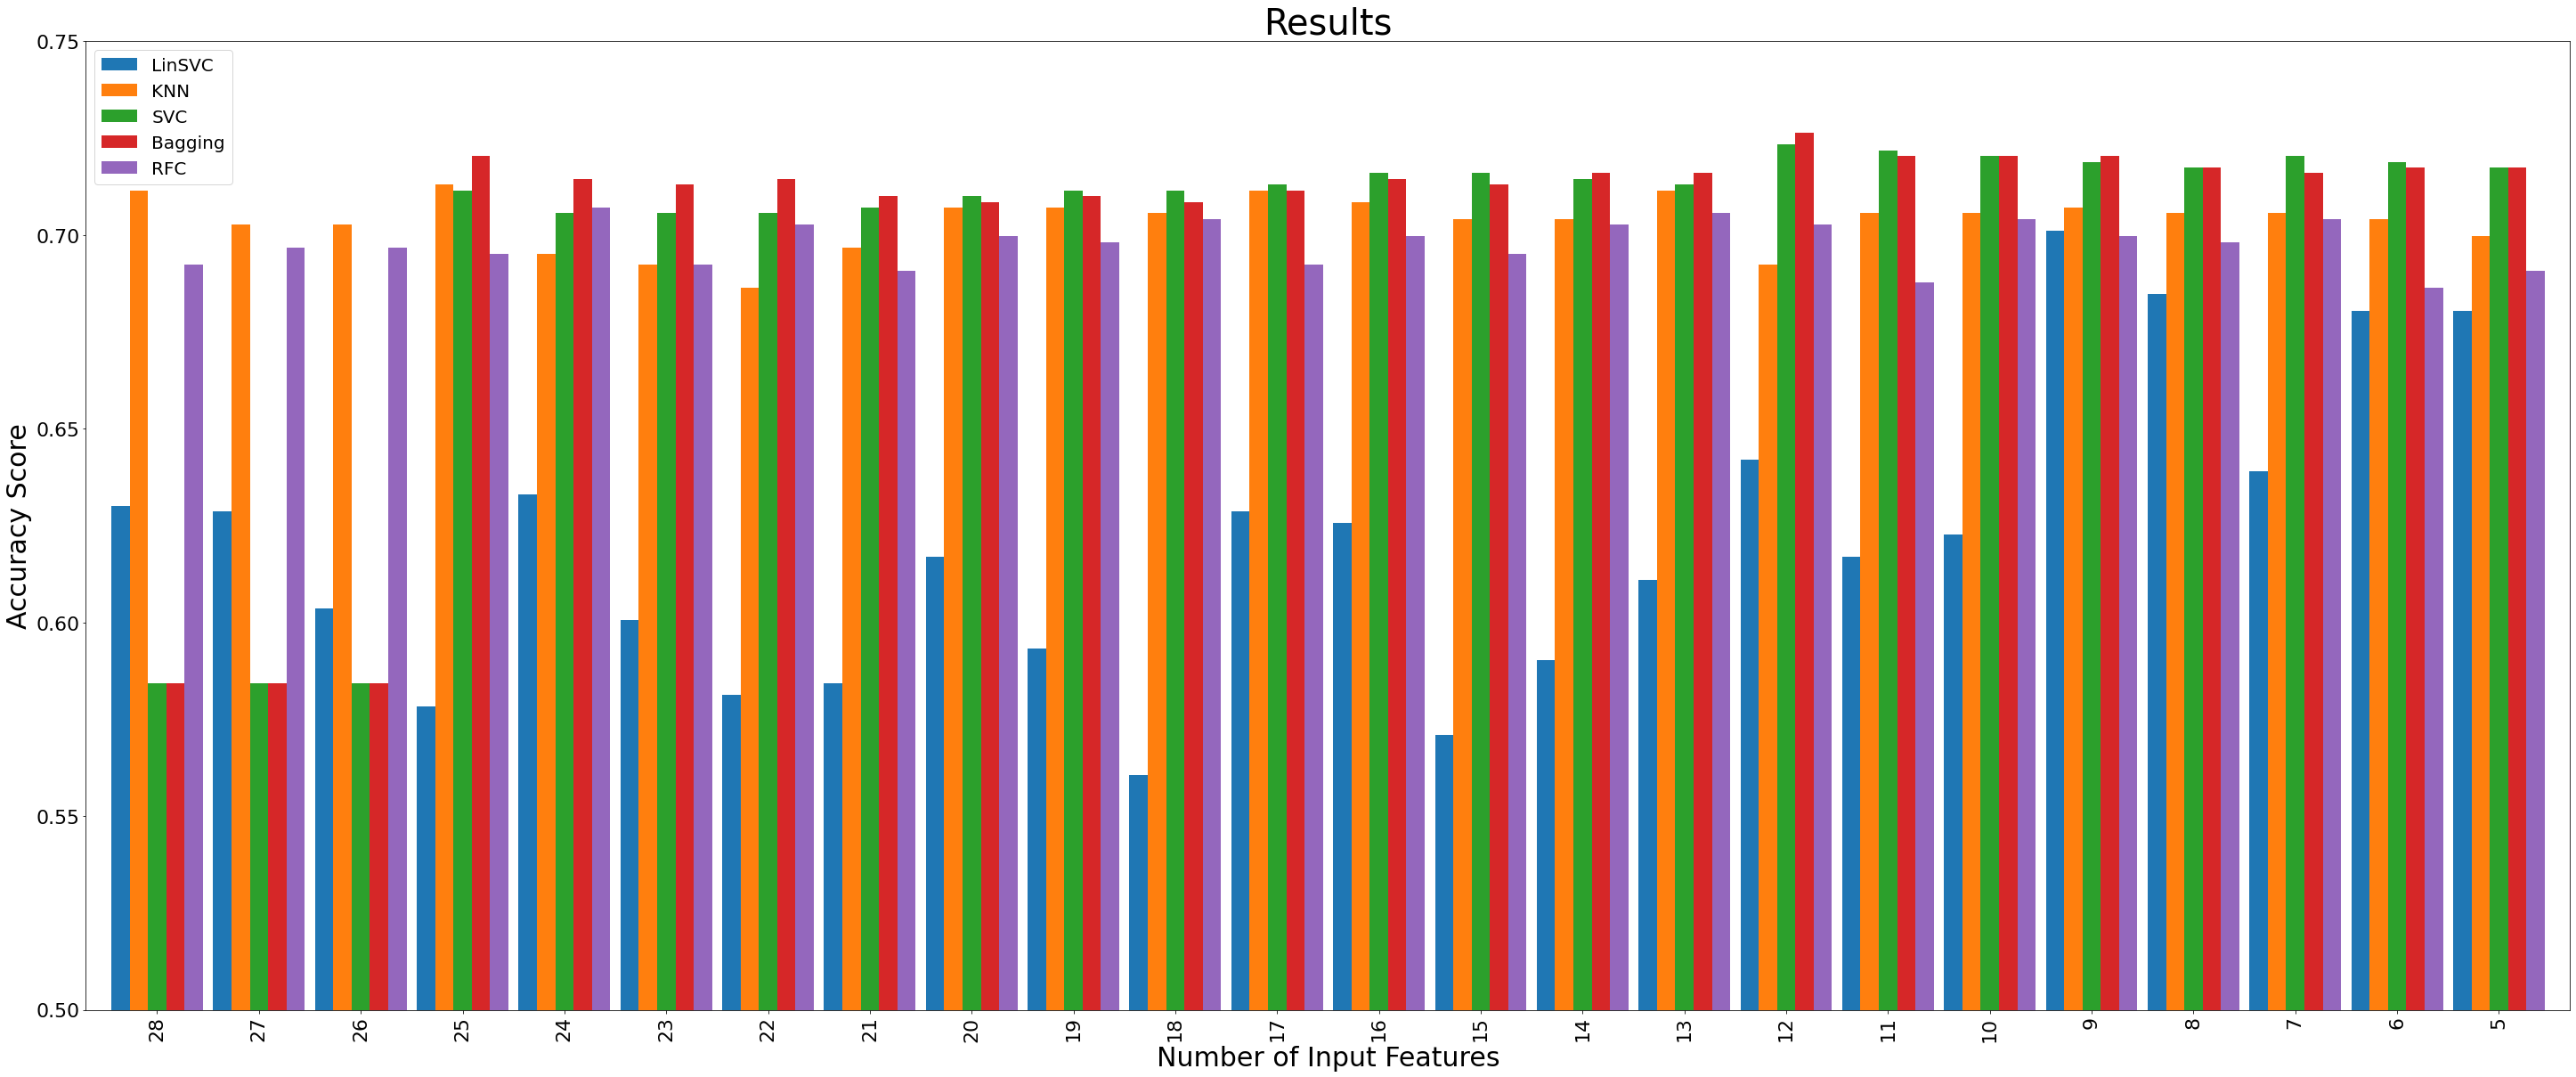

In [ ]:

plt.figure()
plt.rcParams.update({'font.size': 22}) # must set in top

plot_df = models_df.filter(items=['N', 'LinSVC', 'KNN', 'SVC', 'Bagging', 'RFC'])
ax = plot_df.plot.bar(figsize=(50,20), x='N', width=.9)
ax.set_ylim(0.5,0.75)
ax.set_xlabel('Number of Input Features', fontdict={'fontsize':30})
ax.set_ylabel('Accuracy Score', fontdict={'fontsize':30})
ax.legend(fontsize=20)
ax.set_title('Results', fontdict={'fontsize':40})

Text(0.5, 1.0, 'Results')

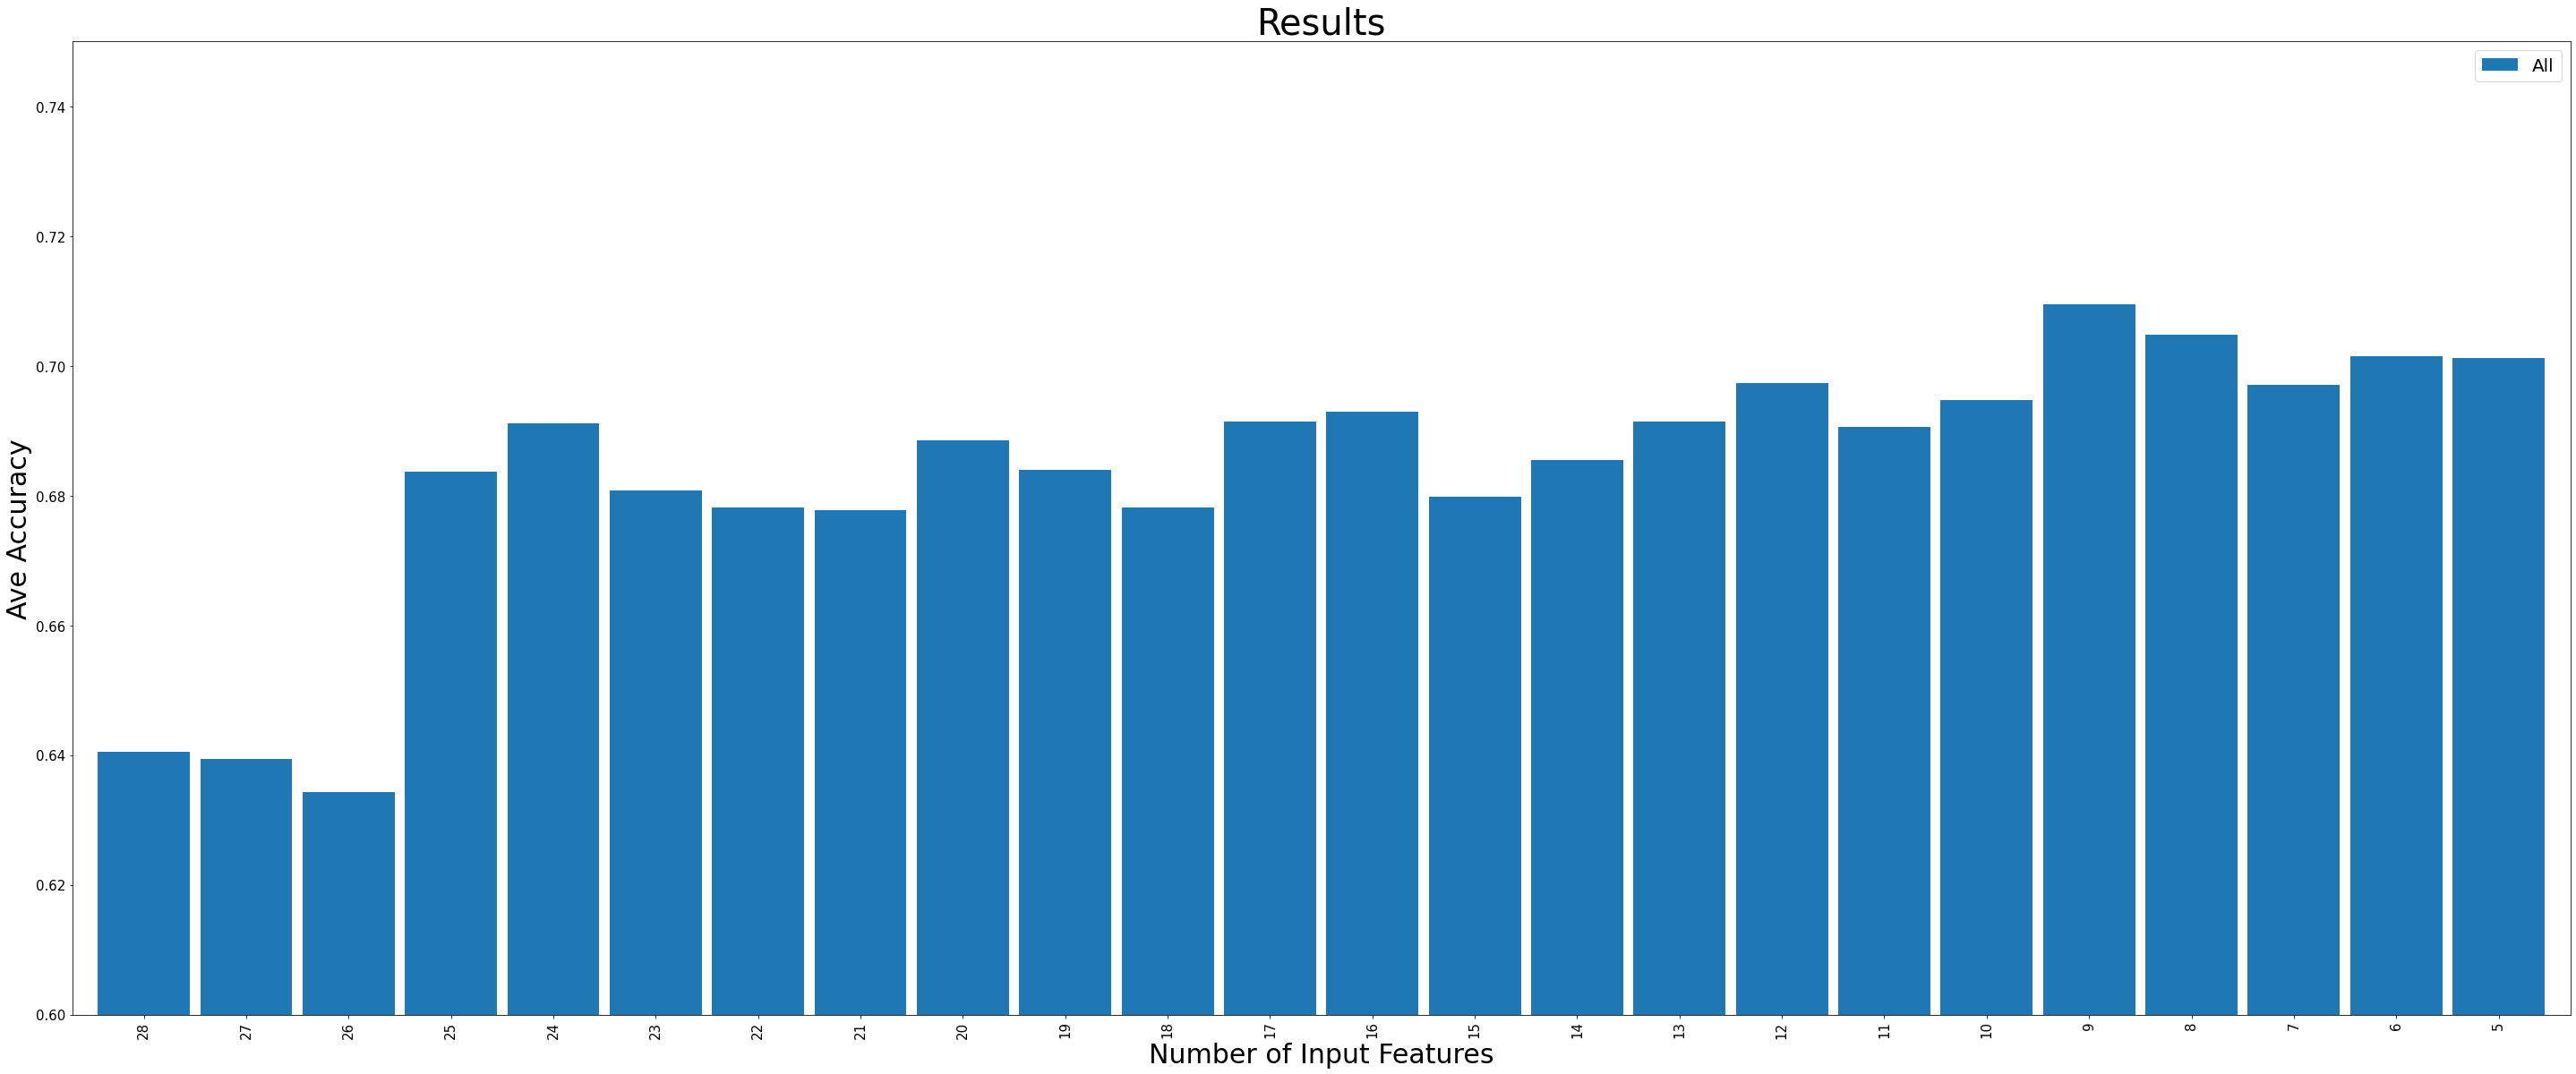

In [ ]:
plot_df2 = models_df.filter(items=['N', 'All'])
ax2 = plot_df2.plot.bar(figsize=(50,20), x='N', width=.9)
ax2.set_ylim(0.6,0.75)
ax2.set_xlabel('Number of Input Features', fontdict={'fontsize':30})
ax2.set_ylabel('Ave Accuracy', fontdict={'fontsize':30})
ax2.legend(fontsize=20)
ax2.set_title('Results', fontdict={'fontsize':40})

In [ ]:
plot_df3 = models_df.copy()

print(plot_df3.sort_values(by=['LinSVC'], ascending=False).filter(items=['N', 'LinSVC']).head(5))
print("\n")

print(plot_df3.sort_values(by=['KNN'], ascending=False).filter(items=['N', 'KNN']).head(5))
print("\n")

print(plot_df3.sort_values(by=['SVC'], ascending=False).filter(items=['N', 'SVC']).head(5))
print("\n")

print(plot_df3.sort_values(by=['Bagging'], ascending=False).filter(items=['N', 'Bagging']).head(5))
print("\n")

print(plot_df3.sort_values(by=['RFC'], ascending=False).filter(items=['N', 'RFC']).head(5))
print("\n")

print(plot_df3.sort_values(by=['All'], ascending=False).filter(items=['N', 'All']).head(5))
print("\n")


     N    LinSVC
19   9  0.701183
20   8  0.684911
23   5  0.680473
22   6  0.680473
16  12  0.642012


     N       KNN
3   25  0.713018
0   28  0.711538
11  17  0.711538
15  13  0.711538
12  16  0.708580


     N       SVC
16  12  0.723373
17  11  0.721893
21   7  0.720414
18  10  0.720414
22   6  0.718935


     N   Bagging
16  12  0.726331
19   9  0.720414
18  10  0.720414
17  11  0.720414
3   25  0.720414


     N       RFC
4   24  0.707101
15  13  0.705621
21   7  0.704142
10  18  0.704142
18  10  0.704142


     N       All
19   9  0.709467
20   8  0.704734
22   6  0.701479
23   5  0.701183
16  12  0.697337




Text(0.5, 1.0, 'Optimal Feature')

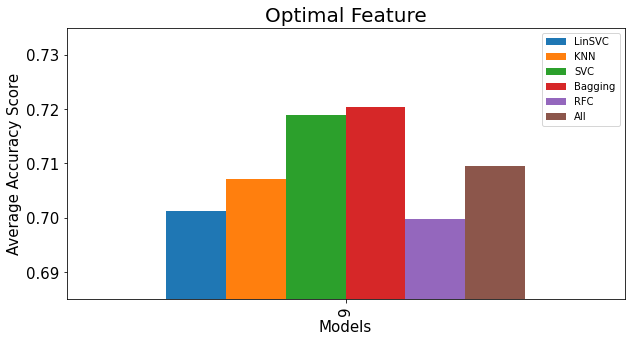

In [ ]:
plt.rcParams.update({'font.size': 15}) # must set in top

plot_df4 = plot_df3[plot_df3['N'] == 9]
plot_df4 = plot_df4.filter(items=['N', 'LinSVC', 'KNN', 'SVC', 'Bagging', 'RFC', 'All'])

ax3 = plot_df4.plot.bar(figsize=(10,5), x='N', width=.9)
ax3.set_ylim(0.685,0.735)
ax3.set_xlabel('Models', fontdict={'fontsize':15})
ax3.set_ylabel('Average Accuracy Score', fontdict={'fontsize':15})
ax3.legend(fontsize=10)
ax3.set_title('Optimal Feature', fontdict={'fontsize':20})

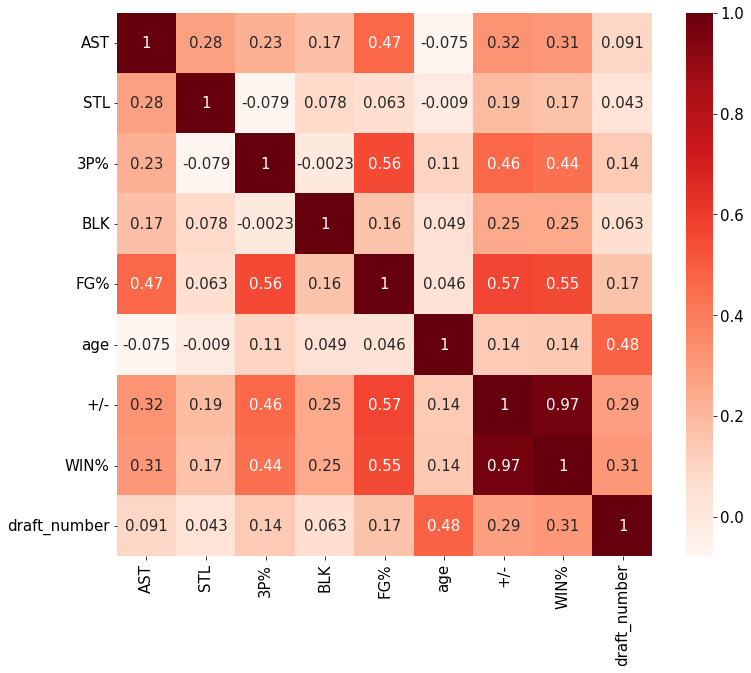

In [ ]:
# Feature 9 heat map
nine_features = relevant_features.index[len(relevant_features)-10: len(relevant_features)-1]

plt.figure(figsize=(12,10))
cor = player_team_data.filter(items=nine_features).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Country Classification

In [ ]:
X = player_team_data.drop(columns=['tot_output'])
y = player_team_data['tot_output']

# Split data into testing and training
feat_train, feat_test, ytrain, ytest = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)


# isolate just country array 
feat_train['country'] = feat_train['country'].astype(int)
con_train = feat_train['country'].copy()
con_test = feat_test['country'].copy()

ytrain = np.zeros(con_train.shape)
ytest = np.zeros(con_test.shape)

# con_train labels  
for j in range(len(con_train)):
  if con_train.iloc[j] == 1: 
    ytrain[j] = 1
  else: 
    ytrain[j] = -1

# con_test labels 
for k in range(len(con_test)):
  if con_test.iloc[k] == 1: 
    ytest[k] = 1
  else: 
    ytest[k] = -1 

clf = svm.SVC() 
clf.fit(feat_train, ytrain)  
pred = clf.predict(feat_test)
accuracy = accuracy_score(pred, ytest)  

print("\n score:", accuracy)
matrix = confusion_matrix(ytest, pred)
print("\n confusion matrix: ", matrix, "\n\n")


 score: 0.8302583025830258

 confusion matrix:  [[  0  46]
 [  0 225]] 


